## Training a TiDE model for the linear dynamic system, $x_{k+1}=Ax_k+Bu_k$
Contributers: Ying-Kuan (Creating the script based on Yi-Ping's TiDE model: generating data, training the model, and plotting) & Yi-Ping (creating the code for TiDE modeling)

updated with longer time series


In [4]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# For LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F

# For TFT
from tqdm import tqdm_notebook as tqdm

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from TiDE import TideModule, quantile_loss

cuda is available


# Preparing for the dynamic system and data

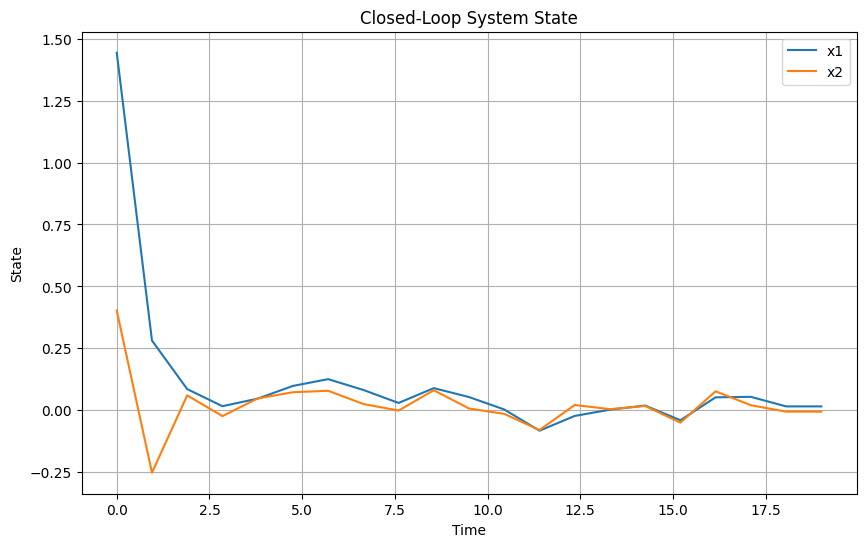

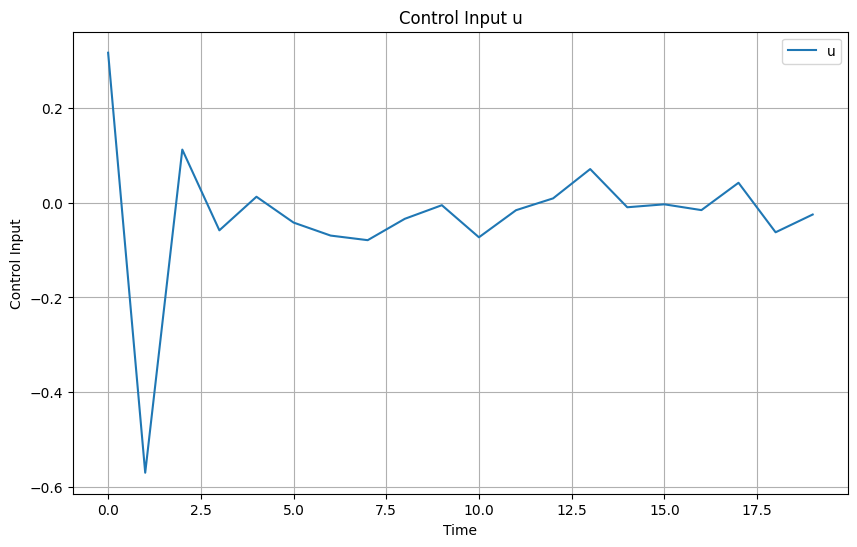

In [5]:
# Define a closed-loop system given initial state, K, tspan, and number of time steps
def f_cl(x0,K,tspan,num_step):
    '''tspan: [0, 10] for example means from 0 to 10 steps'''
    #A = np.array([[1,1],[0,1]])
    A = np.array([[0.3,0.1], [0.1, 0.2]])
    B = np.array([[0.5],[1.0]])
    u_max = 5
    u_min = -5
    t = np.linspace(tspan[0],tspan[1],num_step)
    u = np.zeros(num_step)
    x = np.zeros((2, num_step+1))
    x[:,0] = x0.reshape(1,-1)
    for i in range(len(t)):
        u_tmp = -K@x[:,i]
        u[i] = min(u_max, max(u_min, u_tmp))
        x_tmp = A@x[:,i].reshape(-1,1)+B*u[i]+np.random.normal(0, 0.05, 1)
        x[:,i+1] = x_tmp.reshape(1,-1)
        x[:,i] = x_tmp.reshape(1,-1)
    return x,u

# Given a fixed initial state to see how the response look like
x0 = np.array([[5],[-2]])
K = np.array([0.2068,0.6756])
tspan = [0,19]
num_step = 20
x, u = f_cl(x0,K,tspan,num_step)

# Plotting x
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(tspan[0], tspan[1], num_step+1), x[0], label='x1')
plt.plot(np.linspace(tspan[0], tspan[1], num_step+1), x[1], label='x2')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Closed-Loop System State')
plt.legend()
plt.grid(True)
plt.show()

# Plotting u
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(tspan[0], tspan[1], num_step), u, label='u')
plt.xlabel('Time')
plt.ylabel('Control Input')
plt.title('Control Input u')
plt.legend()
plt.grid(True)
plt.show()

(2, 1)


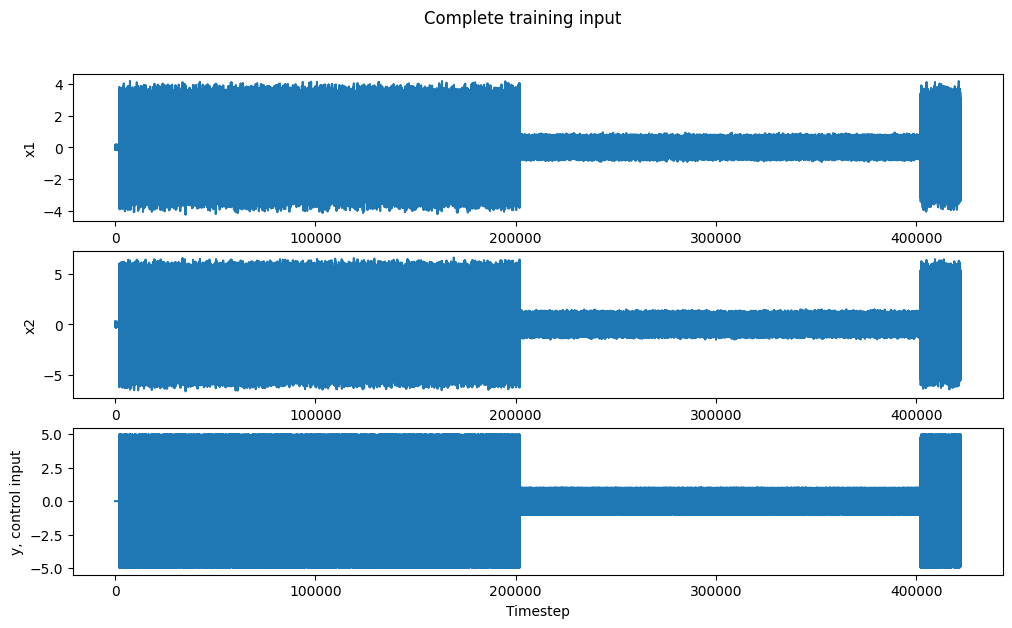

In [6]:
# Generate a sequence of control input and get system dynamic output
# First define a open-loop controlled system
def f_ss(x0,u):
    #A = np.array([[1,1],[0,1]])
    A = np.array([[0.3,0.1], [0.1, 0.2]])
    B = np.array([[0.5],[1.0]])
    mu = np.array([[0],[0]])*0
    w = np.array([[0.05],[0.1]])
    x = A@x0+B*u + np.random.normal(mu,w,size=(2,1))
    return x

# Then define a system enabling multistep input of u
def f_ss_multistep(x0,u):
    step = len(u)
    output = np.zeros([2,step])
    for i in range(step):
        x_next = f_ss(x0,u[i])
        x0 = np.copy(x_next)
        output[:,i] = x_next.reshape(-1)
    return output

K = np.array([-0.6167,-1.2703])
tspan = [0, 200000]
num_step = 20001
#x0 = np.array([[2.0],[1.0]])
x0 = np.array([[0],[0]])
print(x0.shape)
# u_rand = np.random.uniform(low=-1, high=1, size=(2000))
# # u_rand = np.append(u_rand,(np.random.uniform(low=-1, high=1, size=(20000))))
# u_seq = np.append(np.zeros(2000),u_rand)
# u_rand_flat = np.repeat(np.random.uniform(low=-1,high=1, size=(100)),20)
# u_seq = np.append(u_seq,u_rand_flat)
# # u_rand_flat = np.repeat(np.random.uniform(low=-1,high=1, size=(300)),40)
# # u_seq = np.append(u_seq,u_rand_flat)
# u_rand = np.tile(u_rand,10)
# # u_rand = np.append(u_rand,(np.random.uniform(low=-1, high=1, size=(20))))

### copied from the past files
# u_rand = np.random.uniform(low=-1, high=1, size=(100))
# u_seq = np.repeat(u_rand, 200)

### copied from the past files
u_rand = np.random.uniform(low=-5, high=5, size=(200000))
u_rand = np.append(u_rand,(np.random.uniform(low=-1, high=1, size=(200000))))
u_rand = np.append(u_rand,(np.random.uniform(low=-5, high=5, size=(20000))))
u_seq = np.append(np.zeros(2000),u_rand)

#u_seq = np.random.uniform(low=-5, high=5, size=(50))

def dynamic_data_generator(x0,u_seq):
    repeat_LQR = 5
    step = len(u_seq)
    output = np.zeros([x0.shape[0],step])
    count = repeat_LQR
    out_bound_index = False
    for i in range(step):
        u_max = 3 + 2 * np.random.random(1)
        u_min = -u_max
        x_next = f_ss(x0,u_seq[i])
        x0 = np.copy(x_next)
        if i!=step-1:
            if (abs(x0[0])>5 or abs(x0[1])>6):
                out_bound_index = True
                count = repeat_LQR
                u_seq[i+1] = min(u_max, max(u_min, K@x0.reshape(-1)))
            else:
                if out_bound_index and count!=0:
                    u_seq[i+1] = min(u_max, max(u_min, K@x0.reshape(-1)))
                    count = count-1
                elif count==0:
                    out_bound_index = False
        output[:,i] = x_next.reshape(-1)
    return output, u_seq

# x_output = f_ss_multistep(x0,u_seq)
x_output, u_seq_new = dynamic_data_generator(x0,u_seq)

plt.figure(figsize=(12,6.5))
plt.suptitle("Complete training input")
plt.subplot(3,1,1)
# plt.xlim(0,10100)
plt.plot(x_output[0,:], label="x1")
plt.xlabel("x1, system response")
plt.ylabel("x1")
plt.subplot(3,1,2)
# plt.xlim(0,10100)
plt.plot(x_output[1,:],label="x2")
plt.xlabel("x2, system response")
plt.ylabel("x2")
plt.subplot(3,1,3)
plt.plot(u_seq, drawstyle='steps',label="input")
plt.xlabel("Timestep")
plt.ylabel("y, control input")
# plt.xlim(0,10100)
plt.show()


x = x_output
u = u_seq_new.reshape(1,-1)

Text(0, 0.5, '$x$, control input')

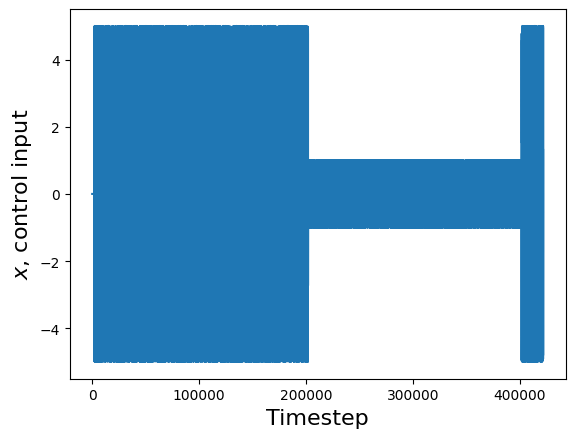

In [7]:
plt.plot(u_seq, drawstyle='steps',label="input")
plt.xlabel("Timestep", fontsize=16)
plt.ylabel("$x$, control input", fontsize=16)

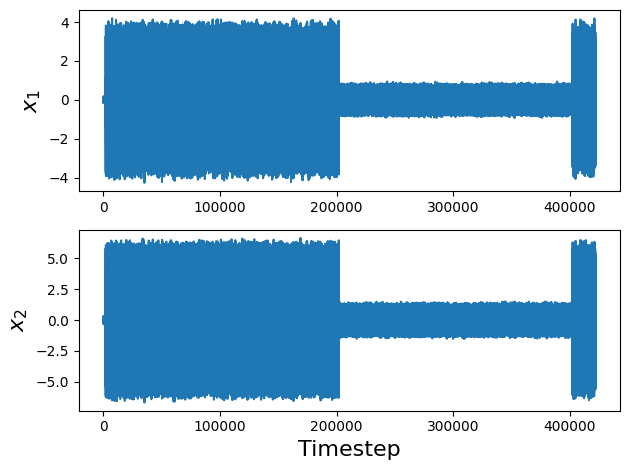

In [8]:
plt.subplot(2,1,1)
# plt.xlim(0,10100)
plt.plot(x_output[0,:], label="x1")
plt.ylabel("$x_1$",fontsize=16)
plt.subplots_adjust(hspace=0.05)
plt.subplot(2,1,2)
# plt.xlim(0,10100)
plt.plot(x_output[1,:],label="x2")
plt.xlabel("Timestep", fontsize=16)
plt.ylabel("$x_2$",fontsize=16)
plt.tight_layout()

In [9]:
import pickle

# Save x and u to a single pickle file
data = {'x': x, 'u': u}

pickle_filename = 'x_and_u.pickle'

with open(pickle_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"Saved 'x' and 'u' arrays to {pickle_filename}")

# Load x and u from the pickle file
pickle_filename = 'x_and_u.pickle'

with open(pickle_filename, 'rb') as f:
    loaded_data = pickle.load(f)

x = loaded_data['x']
u = loaded_data['u']

print("Loaded 'x' array shape:", x.shape)
print("Loaded 'u' array shape:", u.shape)


Saved 'x' and 'u' arrays to x_and_u.pickle
Loaded 'x' array shape: (2, 422000)
Loaded 'u' array shape: (1, 422000)


In [10]:
x.shape


(2, 422000)

In [11]:
window = 10
P = 10

# Function to normalize an array to the scale of -1 and 1
def normalize_array(arr):
    if arr.shape[0]>1:
        min_val = np.min(arr,axis=1).reshape(-1,1)
        max_val = np.max(arr, axis = 1).reshape(-1,1)
        diff = (max_val - min_val).reshape(-1,1)
        print(diff)
        normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    else:
        min_val = np.min(arr)
        max_val = np.max(arr)
        diff = (max_val - min_val)
        normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    return normalized_arr

x_normalized = normalize_array(x)
u_normalized = normalize_array(u)


Xs = u_normalized.reshape(-1,1)
Ys = x_normalized.transpose()

training_ratio = 0.8 # portion of train set 
cut_index = int(training_ratio*x.shape[1]) # index number to separate the training and validation set
cut_index = 400000

Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

# save model parameters
model_params = dict()
model_params["x_min"] = np.min(x,axis=1)
model_params["x_max"] = np.max(x,axis=1)
model_params["u_min"] = np.min(u,axis=1)
model_params["u_max"] = np.max(u,axis=1)
model_params["window"] = window
model_params["P"] = P



print(f"Xs (normalized u sequence) shape = {Xs.shape}, Ys (normalized x1-x2 sequence) shape = {Ys.shape}")



[[ 8.45325163]
 [13.31355118]]
Xs (normalized u sequence) shape = (422000, 1), Ys (normalized x1-x2 sequence) shape = (422000, 2)


In [12]:
''' 
Input data should follows the format: [Batch size, input sequence length (window + P), numbers of features]
Output data should follows the format: [Batch size, output sequence length (P), numbers of features]
'''

# Split data into fragments of proper window size
X_train = []
X_train_past = []
Y_train = []

for i in range(window, len(Xs_train)-P):
    # past x
    X_train.append((Xs_train[i-window:i+P,0]))
    # past y
    Ys_train_add = np.copy(Ys_train[i-window:i,:])
    # Ys_train_add[:-1,:] = 0
    # Ys_train_add[:,:] = 0
    X_train_past.append(Ys_train_add)
    # future y (target)
    Y_train.append(Ys_train[i:i+P,:])

X_val = []
X_val_past = []
Y_val = []

for i in range(window, len(Xs_val)-P):
    # past x
    X_val.append(Xs_val[i-window:i+P,0])
    # past y
    Ys_val_add = np.copy(Ys_val[i-window:i,:])
    # Ys_val_add[:-1,:] = 0
    # Ys_val_add[:,:] = 0
    X_val_past.append(Ys_val_add)
    # future y(target)
    Y_val.append(Ys_val[i:i+P,:])



# Reshape data to the format accepted by LSTM
X_train_array = np.array(X_train)
X_train_array = X_train_array.reshape(X_train_array.shape[0],X_train_array.shape[1],1)
print(X_train_array.shape)
X_train_orig = torch.tensor(X_train_array).type(torch.float32).to(device)                                 # (past + future) covariate, length = window + P
X_train_past_orig = torch.tensor(np.array(X_train_past)).type(torch.float32).to(device)               # past covariate + past series, length = window, dim = input_dim + output_dim
Y_train_orig = torch.tensor(np.array(Y_train)).type(torch.float32).to(device)                        # target: future output, length = P

X_val_array = np.array(X_val)
X_val_array = X_val_array.reshape(X_val_array.shape[0],X_val_array.shape[1],1)
print(X_val_array.shape)
X_val_orig = torch.tensor(X_val_array).type(torch.float32).to(device)                                 # (past + future) covariate, length = window + P
X_val_past_orig = torch.tensor(np.array(X_val_past)).type(torch.float32).to(device)               # past covariate + past series, length = window, dim = input_dim + output_dim
Y_val_orig = torch.tensor(np.array(Y_val)).type(torch.float32).to(device)                        # target: future output, length = P

# Training set
X_past = torch.cat([X_train_past_orig[:,:],X_train_orig[:,:window]],dim=2)
X_future_covariates = X_train_orig[:,-P:,:]

x_in = [X_past, X_future_covariates, None] # Training input
Y_in = Y_train_orig[:,:,:].to(device)   # Training output


# Validation set
X_past_val = torch.cat([X_val_past_orig[:,:],X_val_orig[:,:window,:]],dim=2)
X_future_covariates_val = X_val_orig[:,-P:,:]

x_val = [X_past_val, X_future_covariates_val,None] # Validation input
Y_val = Y_val_orig[:,:,:].to(device)             # Validation output


print(f"x_past shape = {X_past.shape}, x_future_covariate shape = {X_future_covariates.shape}, target shape = {Y_in.shape}")
print(f"x_past_val shape = {X_past_val.shape}, x_future_covariate_val shape = {X_future_covariates_val.shape}, target_val shape = {Y_val.shape}")        # Validation output
    


(399980, 20, 1)
(21980, 20, 1)
x_past shape = torch.Size([399980, 10, 3]), x_future_covariate shape = torch.Size([399980, 10, 1]), target shape = torch.Size([399980, 10, 2])
x_past_val shape = torch.Size([21980, 10, 3]), x_future_covariate_val shape = torch.Size([21980, 10, 1]), target_val shape = torch.Size([21980, 10, 2])


# Build TiDE Model

In [13]:
output_dim = 2
future_cov_dim = 1

nominal_TiDE = TideModule(
        input_dim = output_dim + future_cov_dim,
        output_dim = output_dim,
        future_cov_dim = future_cov_dim,
        static_cov_dim = 0,
        input_chunck_length = window,
        output_chunk_length = P,
        nr_params = 3,
        num_encoder_layers = 1,
        num_decoder_layers = 1,
        decoder_output_dim = 16,
        hidden_size = 128,
        temporal_decoder_hidden = 32,
        temporal_width_past = 4,
        temporal_width_future = 4,
        use_layer_norm = True,
        dropout = 0.2,
    ).to(device)

# for unstable system
# # Define optimizer, loss function, and metrics
# optimizer = torch.optim.Adam(nominal_TiDE.parameters(),lr=0.001, weight_decay=0.002)

# # Add a LR decay
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.67)

# for stable system
# Define optimizer, loss function, and metrics
optimizer = torch.optim.Adam(nominal_TiDE.parameters(),lr=0.001, weight_decay=0.002)

# # Add a LR decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

#criterion = torch.nn.MSELoss()
num_epoch = 1500

model_params["model"] = nominal_TiDE

path = ''
dump(model_params, open(path + 'nominal_params_w10_mid_noise_stable.pkl', 'wb'))

In [14]:
# Create DataLoader for training data
train_dataset = TensorDataset(X_past, X_future_covariates,Y_in)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

best_model = None
best_val_loss = float("inf")

save_train_loss = np.zeros(num_epoch)
save_val_loss = np.zeros(num_epoch)

counter = 0
patience = 50

epoch = 0
loss = 0
val_loss = 0


with tqdm(total=num_epoch, desc=f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}") as pbar:
    for epoch in range(num_epoch):
        for x_past, x_future, y_in in train_loader:
            x_in = [x_past, x_future, None]

            nominal_TiDE.train()
            optimizer.zero_grad()
            output = nominal_TiDE(x_in)
            quantiles = [0.05,0.50,0.95]
            loss = quantile_loss(output,y_in,quantiles)
            loss.backward()
            optimizer.step()

        nominal_TiDE.eval()
        val_out = nominal_TiDE(x_val)
        val_loss = quantile_loss(val_out,Y_val,quantiles)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = nominal_TiDE.state_dict()
            counter = 0
        # else:
        #     counter += 1
        #     if counter >= patience:
        #         print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
        #         break
            
            
        save_train_loss[epoch] = loss
        save_val_loss[epoch] = val_loss

        # if epoch % 20 == 0:
        #     print(f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}")

        scheduler.step()
        pbar.set_description(f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}")
        pbar.update(1)

# Save the model (state_dict) after training
torch.save(nominal_TiDE.state_dict(), 'nominal_params_w10_mid_noise_stable.pth')


Epoch = 0, Train loss = 0.0000, Val loss = 0.0000:   0%|          | 0/1500 [00:00<?, ?it/s]

In [15]:
import os
current_directory = os.getcwd()
file_name = 'nominal_params_w10_mid_noise_stable.pth'
save_path = os.path.join(current_directory, file_name)

torch.save(best_model, save_path)


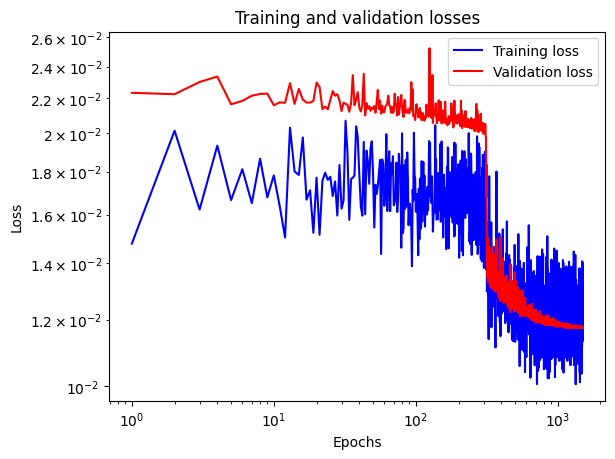

In [16]:
# Load the model with the smallest validation loss (if needed)
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w1_more.pth'))

# Plot loss
loss = save_train_loss
val_loss = save_val_loss
epochs=range(1,len(loss)+1)
plt.figure()
plt.semilogy(epochs, loss,'b', label='Training loss')
plt.semilogy(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
#plt.savefig('lossLSTM32.png')
plt.show()

In [33]:
# Concatenate the variables horizontally
combined = np.vstack((save_val_loss, save_train_loss))

# Save to a single CSV file
pd.DataFrame(combined).to_csv('loss_history.csv', index=False, header=False)

forward time = 0.0009992122650146484


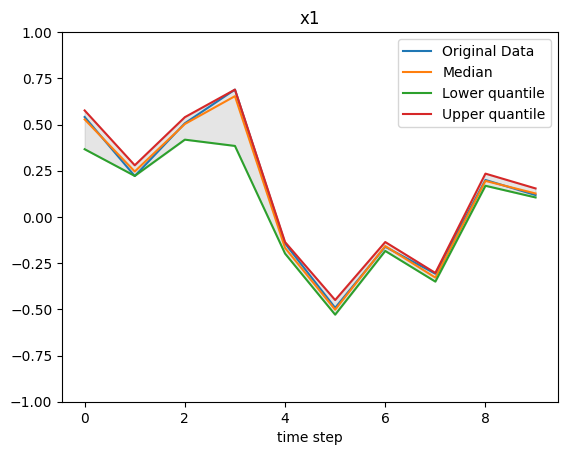

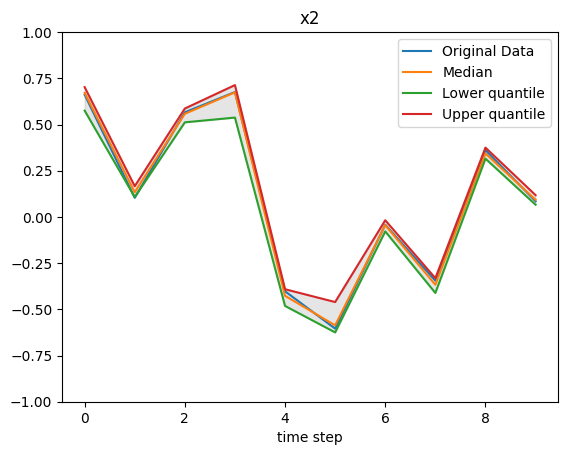

In [27]:
item = 9100 # Select the index for visualizing the results using validation data
item = 3832


x_plot_past = X_past_val[item,:,:].unsqueeze(0)
x_plot_future = X_future_covariates_val[item,:,:].unsqueeze(0)
x_plot_val = [x_plot_past, x_plot_future, None]
y_plot_val = Y_val[item,:,:].unsqueeze(0)

nominal_TiDE.eval()

time1 = time.time()
y_hat = nominal_TiDE(x_plot_val)
time2 = time.time()
print(f"forward time = {time2-time1}")

# plot x1
plt.figure()
plt.plot(y_plot_val.to("cpu")[:,:,0].squeeze().numpy(),label="Original Data")
plt.plot(y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy(),label="Median")
plt.plot(y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy(),label="Lower quantile")
plt.plot(y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy(),label="Upper quantile")
plt.title('x1')
plt.xlabel('time step')
plt.ylim(-1,1)
# plt.ylim([-10,5])

plt.fill_between(range(P),
                 y1=y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy(),
                 y2=y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy(),
                 alpha=0.2, color='gray')
plt.legend()

# plot x2
plt.figure()
plt.plot(y_plot_val.to("cpu")[:,:,1].squeeze().numpy(),label="Original Data")
plt.plot(y_hat[:,:,1,1].squeeze().detach().to("cpu").numpy(),label="Median")
plt.plot(y_hat[:,:,1,0].squeeze().detach().to("cpu").numpy(),label="Lower quantile")
plt.plot(y_hat[:,:,1,2].squeeze().detach().to("cpu").numpy(),label="Upper quantile")
plt.title('x2')
plt.xlabel('time step')
# plt.ylim([-5,2])

plt.fill_between(range(P),
                 y1=y_hat[:,:,1,0].squeeze().detach().to("cpu").numpy(),
                 y2=y_hat[:,:,1,2].squeeze().detach().to("cpu").numpy(),
                 alpha=0.2, color='gray')
plt.legend()
plt.ylim(-1,1)
plt.show()

In [43]:
true_x1 = y_plot_val.to("cpu")[:,:,0].squeeze().numpy()
median_x1 = y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy()
lb_x1 = y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy()
ub_x1 = y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy()

true_x2 = y_plot_val.to("cpu")[:,:,1].squeeze().numpy()
median_x2 = y_hat[:,:,1,1].squeeze().detach().to("cpu").numpy()
lb_x2 = y_hat[:,:,1,0].squeeze().detach().to("cpu").numpy()
ub_x2 = y_hat[:,:,1,2].squeeze().detach().to("cpu").numpy()

save_predict_response = np.vstack([true_x1,median_x1,lb_x1,ub_x1,true_x2,median_x2,lb_x2,ub_x2])
# Save to a single CSV file
pd.DataFrame(save_predict_response).to_csv('save_response_evaluation.csv', index=False, header=False)

### Evaluation

In [18]:
def sMAPE(y_true,y_hat):
    MAPE_ind = 100* np.mean(np.abs((y_true - y_hat) / (np.abs(y_true)+np.abs(y_hat))))
    return MAPE_ind

def SSE_compute(y_true, y_hat):
    return np.sum((y_true - y_hat)**2)

# Main code for eval
MAPE_x1 = []
MAPE_x2 = []
SSE_x1 = 0
SSE_x2 = 0


for item in range(X_past_val.shape[0]):
    x_past = X_past_val[item,:,:].unsqueeze(0)
    x_future = X_future_covariates_val[item,:,:].unsqueeze(0)
    x_val = [x_past, x_future, None]
    y_val = Y_val[item,:,:].unsqueeze(0)
    y_hat = nominal_TiDE(x_val)
    # sMAPE
    MAPE_x1.append(sMAPE(y_val.to("cpu")[:,:,0].squeeze().numpy(), y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy()))
    MAPE_x2.append(sMAPE(y_val.to("cpu")[:,:,1].squeeze().numpy(), y_hat[:,:,1,1].squeeze().detach().to("cpu").numpy()))
    # RMSE
    SSE_x1 = SSE_x1 + SSE_compute(y_val.to("cpu")[:,:,0].squeeze().numpy(), y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy())
    SSE_x2 = SSE_x2 + SSE_compute(y_val.to("cpu")[:,:,1].squeeze().numpy(), y_hat[:,:,1,1].squeeze().detach().to("cpu").numpy())


n_item = Y_val.shape[0] * Y_val.shape[1]
RRMSE_x1 = np.sqrt(np.sum(SSE_x1)/n_item/np.var(Ys_val[:,0]))*100
RRMSE_x2 = np.sqrt(np.sum(SSE_x2)/n_item/np.var(Ys_val[:,1]))*100


MAPE_x1 = np.mean(MAPE_x1)
MAPE_x2 = np.mean(MAPE_x2)

print(f"MAPE_x1 = {MAPE_x1:.2f}%, MAPE_x2 = {MAPE_x2:.2f}%")   
print(f"RRMSE_x1 = {RRMSE_x1:.2f}, RRMSE_x2 = {RRMSE_x2:.2f}")  

MAPE_x1 = 5.96%, MAPE_x2 = 5.50%
RRMSE_x1 = 4.19, RRMSE_x2 = 4.14
